In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)

In [3]:
# class SkipGramFoo(torch.nn.Module):
#   def __init__(self, voc: int, emb: int, _):
#     super().__init__()
#     self.emb = torch.nn.Embedding(num_embeddings=voc, embedding_dim=emb)
#     self.ffw = torch.nn.Linear(in_features=emb, out_features=voc, bias=False)
#     self.sig = torch.nn.Sigmoid()

#   def forward(self, inpt, trgs, rand):
#     emb = self.emb(inpt)
#     ctx = self.ffw.weight[trgs]
#     rnd = self.ffw.weight[rand]
#     out = torch.bmm(ctx, emb.unsqueeze(-1)).squeeze()
#     rnd = torch.bmm(rnd, emb.unsqueeze(-1)).squeeze()
#     out = self.sig(out)
#     rnd = self.sig(rnd)
#     pst = -out.log().mean()
#     ngt = -(1 - rnd + 10**(-3)).log().mean()
#     return pst + ngt

In [4]:
# args = (len(words_to_ids), 64, 2)
# mFoo = SkipGramFoo(*args)
# print('mFoo', sum(p.numel() for p in mFoo.parameters()))
# opFoo = torch.optim.Adam(mFoo.parameters(), lr=0.003)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# %pip install torchinfo
# from torchinfo import summary

# mFoo

In [6]:
# windows = list(more_itertools.windowed(tokens, 3))
# inputs = [w[1] for w in windows]
# targets = [[w[0], w[2]] for w in windows]
# input_tensor = torch.LongTensor(inputs)
# target_tensor = torch.LongTensor(targets)
# dataset = torch.utils.data.TensorDataset(input_tensor, target_tensor)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

In [7]:
# wandb.init(project='mlx6-word2vec', name='mFoo')
# mFoo.to(device)
# for epoch in range(2):
#   prgs = tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)
#   for inpt, trgs in prgs:
#     inpt, trgs = inpt.to(device), trgs.to(device)
#     rand = torch.randint(0, len(words_to_ids), (inpt.size(0), 2)).to(device)
#     opFoo.zero_grad()
#     loss = mFoo(inpt, trgs, rand)
#     loss.backward()
#     opFoo.step()
#     wandb.log({'loss': loss.item()})

-----

In [73]:
#load the embedding matrix
import joblib
embedding_dict = joblib.load('embeds.pkl')

word_to_id = joblib.load('word_to_ids.pkl')
id_to_word = joblib.load('idx_to_word.pkl')

In [74]:
# embed_dim = 300
# embeddings_tensor = torch.zeros(len(word_to_id), embed_dim, dtype=torch.float32)  # or load your actual weights
embeddings_tensor = torch.tensor([i for i in embedding_dict.values()], dtype=torch.float32)

In [75]:
embeddings_tensor.shape

torch.Size([1244025, 300])

In [46]:
class DocTower(nn.Module):
    def __init__(self, embed_dim, lstm_hidden_dim, output_dim):
        """
        :param vocab_size: Size of the vocabulary.
        :param embed_dim: Dimensionality of token embeddings.
        :param lstm_hidden_dim: Number of hidden units in the LSTM.
        :param output_dim: Final embedding dimension (common space).
        """
        super(DocTower, self).__init__()
        # Maps token indices to embeddings (each of size embed_dim), embed with a given embedding dictionary
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, padding_idx=0, freeze=False)
        # LSTM that processes sequences of embeddings.
        # With batch_first=True, input shape: (batch_size, sequence_length, embed_dim)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True)
        # Final projection to the common embedding space
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x):
        """
        :param x: Tensor of shape (batch_size, sequence_length) containing token indices.
        :return: Tensor of shape (batch_size, output_dim) representing the sentence embedding.
        """
        # Convert token indices to embeddings.
        # Output shape: (batch_size, sequence_length, embed_dim)
        x = self.embedding(x)
        # print(x.shape)
        # The LSTM processes the sequence in order (along the sequence_length dimension)
        # 'output' has shape (batch_size, sequence_length, lstm_hidden_dim)
        # 'hn' (hidden state) has shape (num_layers, batch_size, lstm_hidden_dim)
        output, (hn, cn) = self.lstm(x)
        # print(output.shape)
        # Use the final hidden state from the last LSTM layer.
        # This represents the entire sentence after processing all tokens.
        last_hidden = hn[-1]  # Shape: (batch_size, lstm_hidden_dim)
        
        # Project the LSTM output into the common embedding space.
        return self.fc(last_hidden)


In [47]:
class TwoTowerModel(nn.Module):
    def __init__(self, output_dim, embed_dim, lstm_hidden_dim_query, lstm_hidden_dim_doc):
        super(TwoTowerModel, self).__init__()
        self.query_tower = DocTower(embed_dim, lstm_hidden_dim_query, output_dim)
        self.doc_tower = DocTower(embed_dim, lstm_hidden_dim_doc, output_dim)
        
    def forward(self, query, doc_positive, doc_negative):
        """
        :param query: Tensor of shape (batch_size, query_input_dim)
        :param positive_context: Tensor of shape (batch_size, seq_length) containing token indices
        :param candidate: Tensor of shape (batch_size, query_input_dim) for negative samples
        """
        query_embed = self.query_tower(query)
        positive_embed = self.doc_tower(doc_positive)
        negative_embed = self.doc_tower(doc_negative)
        return query_embed, positive_embed, negative_embed


In [13]:
#prepare the data for the query tower work on the query triplets
import json
with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/data/train_triples_sample.json') as f:
    data = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/train_triples_v1.1.json') as f:
    train = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/valid_triples_v1.1.json') as f:
    val = json.load(f)

In [14]:
average_sentence_length = sum(len(item['query'].split()) for item in data) / len(data)
print(average_sentence_length)#this before stemming and removing stopwords
average_context_length = sum(len(item['positive'].split()) for item in data) / len(data)
print(average_context_length)#this before stemming and removing stopwords

12.0
42.8


In [15]:
from tqdm import tqdm
from utils import tokenize
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliagoryachev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yuliagoryachev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
df_val = pd.DataFrame(val)
df_train = pd.DataFrame(train)
df_tot = pd.concat([df_val, df_train])
queries = df_tot['query'].unique()
train_q, val_q = train_test_split(queries, test_size=0.2, random_state=42)

train = df_tot[df_tot['query'].isin(train_q)]
val = df_tot[df_tot['query'].isin(val_q)]

train = train[['query', 'positive', 'negative']]
val = val[['query', 'positive', 'negative']]
train = train.to_dict('records')
val = val.to_dict('records')

In [17]:
print(len(train), len(val))

606993 151560


In [18]:
#data preparartion

In [19]:
SENT_LEN = 12
CONTEXT_LEN = 50
from nltk.stem import PorterStemmer
import constants

punctuation_map = constants.punctuation_map

def pad_truncate(data, max_len):
    res = []
    for d in tqdm(data):
        clean_sent = tokenize(d, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)
        tokens = clean_sent[:max_len]
        tokens += ['<unk>'] * (max_len - len(tokens))
        res.append(tokens)
    return res


In [20]:
# padded_query = pad_truncate(data, 'query', SENT_LEN)
# padded_positive = pad_truncate(data, 'positive', CONTEXT_LEN)
# padded_negative = pad_truncate(data, 'negative', CONTEXT_LEN)

In [21]:
#convert to indices using the word_to_id dictionary
import joblib
word_to_id = joblib.load('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/word_to_ids.pkl')

In [22]:
#convert to indices
def convert_to_indices(data, word_to_id):
    res = []
    for d in tqdm(data):
        res.append([word_to_id.get(w, word_to_id['<unk>']) for w in d])
    return res

In [23]:
# padded_query = convert_to_indices(padded_query, word_to_id)
# padded_positive = convert_to_indices(padded_positive, word_to_id)
# padded_negative = convert_to_indices(padded_negative, word_to_id)

In [24]:
# padded_query

In [25]:
# padded_positive

In [26]:
batch_size = 64

In [34]:
#Wrap in dataset and dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class QueryDataset(Dataset):
    def __init__(self, data, SENT_LEN, CONTEXT_LEN):
        self.queries = [d['query'] for d in data]
        self.positives = [d['positive'] for d in data]
        self.negatives = [d['negative'] for d in data]
        #pad truncates the data
        self.queries = pad_truncate(self.queries, SENT_LEN)
        self.positives = pad_truncate(self.positives, CONTEXT_LEN)
        self.negatives = pad_truncate(self.negatives, CONTEXT_LEN)
        #convert to indices
        self.queries = convert_to_indices(self.queries, word_to_id)
        self.positives = convert_to_indices(self.positives, word_to_id)
        self.negatives = convert_to_indices(self.negatives, word_to_id)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        return torch.tensor(self.queries[idx], dtype=torch.long), \
                torch.tensor(self.positives[idx], dtype=torch.long), \
                torch.tensor(self.negatives[idx], dtype=torch.long)
    
    def collate_fn(batch):
        queries, positives, negatives = zip(*batch)
        queries = torch.stack(queries)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)
        return queries, positives, negatives
    

# Wrap in dataset and dataloader
train_dataset = QueryDataset(train[:len(train)//100], SENT_LEN, CONTEXT_LEN)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=QueryDataset.collate_fn)

val_dataset = QueryDataset(val[:len(val)//100], SENT_LEN, CONTEXT_LEN)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=QueryDataset.collate_fn)

100%|██████████| 1515/1515 [00:00<00:00, 172644.96it/s]


In [35]:
for i in train_loader:
    keep_one = i
    print(i)
    print(i[0].shape)
    print(i[1].shape)
    break

(tensor([[1026038, 1177178,       0,       0,       0,       0,       0,       0,
               0,       0,       0,       0],
        [ 324325, 1029836,  196840,  253613,       0,       0,       0,       0,
               0,       0,       0,       0],
        [  16174,  393570,  780327,       0,       0,       0,       0,       0,
               0,       0,       0,       0],
        [1121428,  729511,  270199,  393707,  270199,       0,       0,       0,
               0,       0,       0,       0],
        [  36662,    7263,  289592,  629197,  813056,       0,       0,       0,
               0,       0,       0,       0],
        [ 287865,  774994, 1128577,       0,       0,       0,       0,       0,
               0,       0,       0,       0],
        [ 426508,  996290,  559135,  115534,  394637,  469757,       0,       0,
               0,       0,       0,       0],
        [ 619059, 1216629,       0,       0,       0,       0,       0,       0,
               0,       0,   

In [36]:
idx_to_word = joblib.load('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/idx_to_word.pkl')

print('The query')
print('========')
for i in keep_one[0][0]:
    #convert i from tensor to index
    print(idx_to_word[i.item()])
print('The positive')
print('========')
for i in keep_one[1][0]:
    #convert i from tensor to index
    print(idx_to_word[i.item()])

The query
nether
crystal
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
The positive
visit
minecraft
wiki
basic
inform
nether
quartz
bunch
nether
quartz
ore
nether
quartz
ore
one
ore
gather
nether
mine
pickax
nether
quartz
ore
also
avail
vanilla
minecraft
build
materi
sever
thing
hexxit
use
edit
mine
nether
quartz
get
quartz
ore
craft
thing
ore
giant
sword
shield
block
quartz
craft
quartz


In [37]:
len(embedding_dict)

1244025

In [31]:
# # Hyperparameters (example values)
# query_sequence_length = SENT_LEN
# doc_sequence_length = CONTEXT_LEN
# output_dim = 128
# embed_dim = 300
# lstm_hidden_dim = 64
# batch_size = 64

# # Instantiate the model
# model = TwoTowerModel(query_sequence_length, doc_sequence_length, output_dim, embed_dim, lstm_hidden_dim)


# # Define triplet loss
# triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, query, pos_doc, neg_doc):
#         # Normalize embeddings to compute cosine similarity
#         query_norm = query / query.norm(dim=1, keepdim=True)
#         pos_doc_norm = pos_doc / pos_doc.norm(dim=1, keepdim=True)
#         neg_doc_norm = neg_doc / neg_doc.norm(dim=1, keepdim=True)
        
#         # Compute cosine similarities
#         pos_sim = torch.sum(query_norm * pos_doc_norm, dim=1) 
#         neg_sim = torch.sum(query_norm * neg_doc_norm, dim=1)
        
#         # Compute triplet loss
#         loss = torch.max(neg_sim - pos_sim + self.margin, torch.tensor(0)).mean()
#         return loss


# # Dummy inputs:
# # Query and candidate inputs (feature vectors)
# #random integers tensor
# query = torch.randint(0, 10, (batch_size, query_sequence_length))
# doc_positive = torch.randint(0, 20, (batch_size, doc_sequence_length))
# doc_negative = torch.randint(0, 20, (batch_size, doc_sequence_length))

# # Forward pass
# query_embed, positive_embed, candidate_embed = model(query, doc_positive, doc_negative)
# query_embed = query_embed.float()
# positive_embed = positive_embed.float()
# candidate_embed = candidate_embed.float()

# # Compute loss (assuming query is the anchor, positive_embed is the positive, and candidate_embed is the negative)
# # loss = triplet_loss_fn(query_embed, positive_embed, candidate_embed)
# margin = 1.0
# loss = TripletLoss(margin)(query_embed, positive_embed, candidate_embed)
# print(f"Triplet loss: {loss.item()}")

In [38]:
for i in val_loader:
    keep_one = i
    print(i)
    print(i[0].shape)
    print(i[1].shape)
    break

(tensor([[ 463058,  147547, 1148302,  686402,       0,       0,       0,       0,
               0,       0,       0,       0],
        [ 463058,  147547, 1148302,  686402,       0,       0,       0,       0,
               0,       0,       0,       0],
        [ 463058,  147547, 1148302,  686402,       0,       0,       0,       0,
               0,       0,       0,       0],
        [ 463058,  147547, 1148302,  686402,       0,       0,       0,       0,
               0,       0,       0,       0],
        [ 463058,  147547, 1148302,  686402,       0,       0,       0,       0,
               0,       0,       0,       0],
        [1232025, 1004990, 1198195,       0,       0,       0,       0,       0,
               0,       0,       0,       0],
        [1232025, 1004990, 1198195,       0,       0,       0,       0,       0,
               0,       0,       0,       0],
        [1232025, 1004990, 1198195,       0,       0,       0,       0,       0,
               0,       0,   

In [48]:
# Hyperparameters (example values)
query_sequence_length = SENT_LEN
doc_sequence_length = CONTEXT_LEN
output_dim = 128
embed_dim = 300
lstm_hidden_dim_query = 16
lstm_hidden_dim_doc = 32
batch_size = 64

# Instantiate the model
model = TwoTowerModel(output_dim, embed_dim, lstm_hidden_dim_query, lstm_hidden_dim_doc)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, query, pos_doc, neg_doc):
        pos_sim = F.cosine_similarity(query, pos_doc)
        neg_sim = F.cosine_similarity(query, neg_doc)
        
        # Compute triplet loss with margin
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0.0)
        return loss.mean()

margin = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#iterate over batches of the data
train_losses = []
valid_losses = []
epochs = 6
for epoch in range(epochs):
    model.train()
    for i, (query, positive, negative) in enumerate(train_loader):
        query_embed, positive_embed, negative_embed = model(query, positive, negative)
        query_embed = query_embed.float()
        positive_embed = positive_embed.float()
        negative_embed = negative_embed.float()
        optimizer.zero_grad()

        loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
        loss.backward()

        # Backward pass
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")
    train_loss = loss.item()
    train_losses.append(train_loss)


    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  
        for query, positive, negative in val_loader:
            query_embed, positive_embed, negative_embed = model(query, positive, negative)
            query_embed = query_embed.float()
            positive_embed = positive_embed.float()
            negative_embed = negative_embed.float()
            loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
    valid_loss = loss.item()
    valid_losses.append(valid_loss)
    print(f"====Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}====")

Epoch 1, Batch 1, Loss: 0.9996246099472046
Epoch 1, Batch 11, Loss: 0.9835770130157471
Epoch 1, Batch 21, Loss: 0.9470673203468323
Epoch 1, Batch 31, Loss: 0.8852795958518982
Epoch 1, Batch 41, Loss: 0.9981566667556763
Epoch 1, Batch 51, Loss: 0.9994041323661804
Epoch 1, Batch 61, Loss: 0.9999819397926331
Epoch 1, Batch 71, Loss: 0.9887341260910034
Epoch 1, Batch 81, Loss: 0.878925085067749
Epoch 1, Batch 91, Loss: 0.9011058807373047
====Epoch 1, Train Loss: 0.9568487405776978, Validation Loss: 1.0147370100021362====
Epoch 2, Batch 1, Loss: 0.882819414138794
Epoch 2, Batch 11, Loss: 0.7980937957763672
Epoch 2, Batch 21, Loss: 0.7066489458084106
Epoch 2, Batch 31, Loss: 0.5227125883102417
Epoch 2, Batch 41, Loss: 0.45777344703674316
Epoch 2, Batch 51, Loss: 0.5301075577735901
Epoch 2, Batch 61, Loss: 0.5165229439735413
Epoch 2, Batch 71, Loss: 0.6171756386756897
Epoch 2, Batch 81, Loss: 0.5742948055267334
Epoch 2, Batch 91, Loss: 0.43655601143836975
====Epoch 2, Train Loss: 0.5960602164

KeyboardInterrupt: 

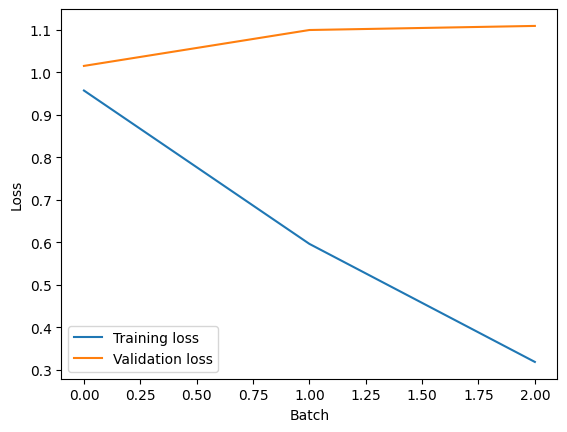

In [49]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [51]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

ind = 3
query = val[ind]['query']
print(query)
query_embed = np.zeros((1, 300))
count_q = 0
for i in tokenize(query, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    query_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

query_embed = query_embed/max(count_q,1)

print('========')
#embed a positive context
positive_embed = np.zeros((1, 300))
count_p = 0
positive = val[ind]['positive']
print(positive)
for i in tokenize(positive, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    positive_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

positive_embed = positive_embed/max(count_p,1)

print('========')
#embed a negative context
negative_embed = np.zeros((1, 300))
count_p = 0
negative = val[ind]['negative']
print(negative)
for i in tokenize(negative, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    negative_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

negative_embed = negative_embed/max(count_p,1)

print(cosine_similarity(query_embed, positive_embed))
print(cosine_similarity(query_embed, negative_embed))

why is albumin normally absent in urine
albumin
463058
normal
147547
absent
1148302
urin
686402
Share. Albumin is a protein present in the blood. Proteins are normally absent in urine because the kidney cells generally prevent large molecules including proteins, from being excreted. Some proteins may appear in the urine in normal individuals also if blood levels are very high. In kidney diseases, albumin will appear in the urine even with normal blood levels.
share
362827
albumin
463058
protein
1067121
present
1104426
blood
20589
protein
1067121
normal
147547
absent
1148302
urin
686402
kidney
1156764
cell
672335
gener
98924
prevent
1210384
larg
586796
molecul
240130
includ
266098
protein
1067121
excret
929268
protein
1067121
may
949696
appear
1167518
urin
686402
normal
147547
individu
950042
also
1004990
blood
20589
level
96856
high
97141
kidney
1156764
diseas
697376
albumin
463058
appear
1167518
urin
686402
even
1048327
normal
147547
blood
20589
level
96856
When you recharge a battery

In [197]:
#check the result
count = 0
for query, positive, negative in val_loader:
    query = query
    doc_pos = positive
    doc_neg = negative
    break

#cosine similarity before the model
query_embed, positive_embed, negative_embed = model(query, doc_pos, doc_neg)
# cosine similarity after the model
print(F.cosine_similarity(query_embed, positive_embed))
print()
print(F.cosine_similarity(query_embed, negative_embed))

tensor([0.9526, 0.8847, 0.7105, 0.9746, 0.9717, 0.9800, 0.9467, 0.4721, 0.7492,
        0.9627, 0.7586, 0.7478, 0.7861, 0.9002, 0.9027, 0.9222, 0.6239, 0.9517,
        0.9648, 0.9623, 0.9572, 0.9199, 0.9705, 0.8857, 0.9699, 0.9610, 0.9766,
        0.6171, 0.9686, 0.9678, 0.9762, 0.8979, 0.7490, 0.9605, 0.9328, 0.9210,
        0.9638, 0.7521, 0.9502, 0.8664, 0.9750, 0.9129, 0.5669, 0.6516, 0.7739,
        0.6517, 0.5709, 0.3252, 0.5668, 0.8254, 0.7096, 0.7283, 0.7669, 0.6039,
        0.5167, 0.9453, 0.9820, 0.9774, 0.9012, 0.9527, 0.9063, 0.9740, 0.9296,
        0.5509], grad_fn=<SumBackward1>)

tensor([-0.9648, -0.9469, -0.4387, -0.9453, -0.9571, -0.6900, -0.9349, -0.9514,
        -0.9353, -0.9609, -0.9639, -0.9457, -0.9591, -0.9656, -0.9635, -0.9333,
        -0.9643, -0.7480, -0.9568, -0.9549, -0.9696, -0.9221, -0.9562, -0.8856,
        -0.9499,  0.7484, -0.9669, -0.9473, -0.9623, -0.7057, -0.9537, -0.9610,
        -0.9463, -0.9740, -0.9531, -0.9527, -0.9057, -0.9614, -0.9332, -0.9759

In [98]:
#find the most similar search
query_text = val[2]['query']
documents_text = [i['positive'] for i in val[:len(val)//100]]
print(query_text)
print(documents_text)

#pad truncates the data
query = pad_truncate([query_text], SENT_LEN)
documents = pad_truncate(documents_text, CONTEXT_LEN)
#convert to indices
query = convert_to_indices(query, word_to_id)
documents = convert_to_indices(documents, word_to_id)

query = torch.tensor(query, dtype=torch.long)
documents = torch.tensor(documents, dtype=torch.long)

model.eval()  # Set model to evaluation mode
with torch.no_grad():  
    query_embed, documents_embed, negative_embed = model(query, documents, documents)

# Compute cosine similarities
query_embed = query_embed.float()
documents_embed = documents_embed.float()
cos = []
for em in documents_embed:
    cos.append(F.cosine_similarity(query_embed, em).item())


why is albumin normally absent in urine
['Albumin is a protein present in the blood. Proteins are normally absent in urine because the kidney cells generally prevent large molecules including proteins, from being excr … eted. Albumin in your urine may be an early sign of kidney problems although some people have small amounts of albumin in their urine normally.', 'A normal amount of albumin in your urine is less that 20 mg a day. A normal total protein amount in your urine is less that 150 mg a day. If your test shows high levels of urine albumin, or a rise in urine albumin, it could mean you have kidney damage or disease.', 'Guide. An albumin test checks urine for a protein called albumin. Albumin is normally found in the blood and filtered by the kidneys. When the kidneys are working as they should, there may be a very small amount of albumin in the urine. But when the kidneys are damaged, abnormal amounts of albumin leak into the urine. This is called albuminuria.', 'Share. Albumin 

100%|██████████| 1515/1515 [00:00<00:00, 169125.16it/s]


In [99]:
np.argmax(cos)

348

In [57]:
torch.Size([32, 12, 300])
torch.Size([32, 12, 64])

torch.Size([32, 12, 64])

In [54]:
#embed a query
query = "How to make a cake"
#pad and truncate
query = pad_truncate([query], 4)
query = convert_to_indices(query, word_to_id)

100%|██████████| 1/1 [00:00<00:00, 6955.73it/s]


In [55]:
import numpy as np
query = train[0]['query']
print(query)
query_embed = np.zeros((1, 300))
count_q = 0
for i in tokenize(query, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    query_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

query_embed = query_embed/max(count_q,1)

print('========')
#embed a positive context
positive_embed = np.zeros((1, 300))
count_p = 0
positive = train[0]['positive']
print(positive)
for i in tokenize(positive, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    positive_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

positive_embed = positive_embed/max(count_p,1)

print('========')
#embed a negative context
negative_embed = np.zeros((1, 300))
count_p = 0
negative = train[0]['negative']
print(negative)
for i in tokenize(negative, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    negative_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

negative_embed = negative_embed/max(count_p,1)

what is rba
rba
722428
Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.
sinc
401098
rba
722428
outstand
426933
reput
307411
affect
1188611
secur
734919
npa
740575
scandal
1018751
rba
722428
subsidiari
1036929
involv
70290
bribe
1027549
oversea
1098502
offici
888271
australia
187620
might
396564
win
276869
lucr
541905
note
287077
print
514386
contract
355724
asset
219015
bank
901419
includ
266098
gold
47891
foreign
572029
exchang
309358
reserv
1200897
australia
187620
estim
975472
net
1190646
worth
1157870
billion
1036595
nearli
21564
rba
722428
employ

In [56]:
#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(query_embed, positive_embed))
print(cosine_similarity(query_embed, negative_embed))

[[0.47809076]]
[[0.08634104]]


In [67]:
(query_embed * positive_embed).sum()/np.linalg.norm(query_embed)/np.linalg.norm(positive_embed)

0.47809076495182673

In [30]:
from typing import List
import numpy as np

In [91]:

train, validation = train_test_split(train, test_size=0.3, random_state=42)

In [92]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
class QueryDataset(Dataset):
    def __init__(self, data):
        self.queries = [d['query'] for d in data]
        self.positives = [d['positive'] for d in data]
        self.negatives = [d['negative'] for d in data]
        print('tokenize')
        self.queries = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.queries)]
        self.positives = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.positives)]
        self.negatives = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.negatives)]

        print('average pooling')
        self.queries = [self.average_pooling(i) for i in tqdm(self.queries)]
        self.positives = [self.average_pooling(i) for i in tqdm(self.positives)]
        self.negatives = [self.average_pooling(i) for i in tqdm(self.negatives)]
    
    def average_pooling(self, data: List[str]):
        embed = np.zeros((1, 300))
        count = 0
        for d in data:
            token = word_to_id.get(d, word_to_id['<unk>'])
            embed+=embedding_dict.get(token, np.zeros(300))
            count+=1
        # print(data,embed)
        return embed/max(count, 1)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        return torch.tensor(self.queries[idx], dtype=torch.float32), \
                torch.tensor(self.positives[idx], dtype=torch.float32), \
                torch.tensor(self.negatives[idx], dtype=torch.float32)
    
    def collate_fn(batch):
        queries, positives, negatives = zip(*batch)
        queries = torch.stack(queries)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)
        return queries, positives, negatives
    

# Wrap in dataset and dataloader
train_dataset = QueryDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=QueryDataset.collate_fn)

val_dataset = QueryDataset(validation)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=QueryDataset.collate_fn)

tokenize


100%|██████████| 473335/473335 [02:22<00:00, 3327.79it/s]


average pooling
tokenize


100%|██████████| 202858/202858 [01:01<00:00, 3322.41it/s]


average pooling


In [93]:
len(train)

473335

In [94]:
# for i in train_dataset:
#     keep_one = i
#     print(i)
#     print(i[0].shape)
#     print(i[1].shape)
#     break

In [95]:
# import os
# import sys
# src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
# if src_path not in sys.path:
#     sys.path.insert(0, src_path)

In [96]:
class OneTower(nn.Module):
    def __init__(self, embed_dim, med_dim, output_dim):
        super(OneTower, self).__init__()
        self.fc = nn.Linear(embed_dim, med_dim)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(med_dim, output_dim)
    
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc1(x)
        return x
    
class TwoTowerModel(nn.Module):
    def __init__(self, embed_dim, med_dim, output_dim):
        super(TwoTowerModel, self).__init__()
        self.query_tower = OneTower(embed_dim, med_dim, output_dim)
        self.doc_tower = OneTower(embed_dim, med_dim, output_dim)
        
    def forward(self, query, doc_positive, doc_negative):
        """
        :param query: Tensor of shape (batch_size, query_input_dim)
        :param positive_context: Tensor of shape (batch_size, seq_length) containing token indices
        :param candidate: Tensor of shape (batch_size, query_input_dim) for negative samples
        """
        query_embed = self.query_tower(query)
        positive_embed = self.doc_tower(doc_positive)
        negative_embed = self.doc_tower(doc_negative)
        return query_embed, positive_embed, negative_embed

In [98]:
# Hyperparameters (example values)
output_dim = 64
med_dim = 128
embed_dim = 300
batch_size = 32

# Instantiate the model
model = TwoTowerModel(embed_dim, med_dim,  output_dim)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, query, pos_doc, neg_doc):
        pos_sim = F.cosine_similarity(query, pos_doc)
        neg_sim = F.cosine_similarity(query, neg_doc)
        
        # Compute triplet loss with margin
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0.0)
        return loss.mean()

margin = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#iterate over batches of the data
train_losses = []
val_losses = []
epochs = 30
for epoch in range(epochs):
    model.train()
    for i, (query, positive, negative) in enumerate(val_loader):
        query_embed, positive_embed, negative_embed = model(query, positive, negative)
        query_embed = query_embed.float()
        positive_embed = positive_embed.float()
        negative_embed = negative_embed.float()
        optimizer.zero_grad()

        loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
        loss.backward()

        # Backward pass
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = loss.item()
            
    # Validation
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():  
        for query, positive, negative in val_loader:
            query_embed, positive_embed, negative_embed = model(query, positive, negative)
            query_embed = query_embed.float()
            positive_embed = positive_embed.float()
            negative_embed = negative_embed.float()
            loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
            valid_loss += loss.item()
        valid_loss = loss.item()
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}")


Epoch 1, Train Loss: 0.10337500274181366, Validation Loss: 0.10026563704013824
Epoch 2, Train Loss: 0.09100000560283661, Validation Loss: 0.07540624588727951
Epoch 3, Train Loss: 0.0566718764603138, Validation Loss: 0.05353124812245369
Epoch 4, Train Loss: 0.05356249213218689, Validation Loss: 0.05976561829447746
Epoch 5, Train Loss: 0.07212499529123306, Validation Loss: 0.07835938036441803
Epoch 6, Train Loss: 0.07848437130451202, Validation Loss: 0.06293749809265137
Epoch 7, Train Loss: 0.04728124290704727, Validation Loss: 0.04729687049984932
Epoch 8, Train Loss: 0.06615625321865082, Validation Loss: 0.06612499803304672
Epoch 9, Train Loss: 0.044218745082616806, Validation Loss: 0.05043749883770943
Epoch 10, Train Loss: 0.059859372675418854, Validation Loss: 0.056734371930360794
Epoch 11, Train Loss: 0.056765615940093994, Validation Loss: 0.05053124576807022
Epoch 12, Train Loss: 0.028656240552663803, Validation Loss: 0.028656240552663803
Epoch 13, Train Loss: 0.0442812480032444, Va

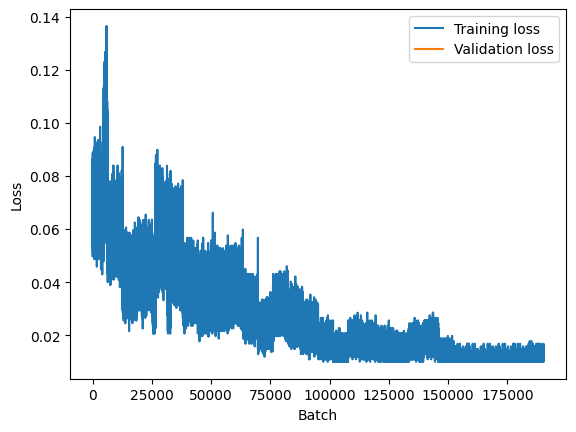

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()